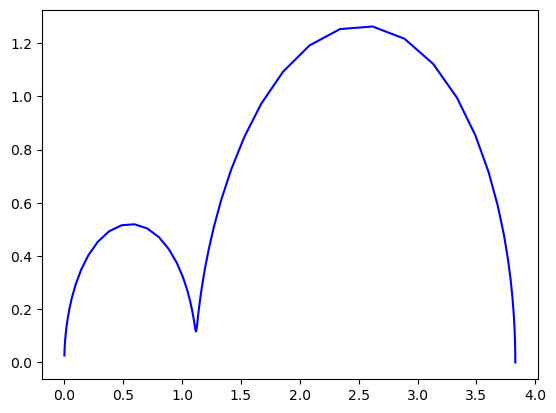

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取阻抗数据
df = pd.read_excel('C:\\Users\\HR\\Nutstore\\1\\ML_EIS\\Manuscripts\\分形分析\\分形阻抗\\细胞阻抗仿真\\紧密连接\\紧密连接dxf\\阻抗Cole\\同周长圆角V3 - 副本.xlsx', sheet_name=0, skiprows=0)
    
df = df.iloc[0:102, [0,2,3]] 
df.columns = ['频率', '阻抗实部', '阻抗虚部']

# 将阻抗实部和虚部转换为数值类型，确保没有字符串
df['阻抗实部'] = pd.to_numeric(df['阻抗实部'], errors='coerce')
df['阻抗虚部'] = pd.to_numeric(df['阻抗虚部'], errors='coerce')

# 计算阻抗：Z = 实部 + i * 虚部
df['阻抗'] = df['阻抗实部'] - 1j * df['阻抗虚部']

# 将阻抗数据转换为 numpy 数组
impedance = np.array(df['阻抗'])
f = np.array(df['频率'])
tau = 1/(2*np.pi*f)
omega = 2*np.pi*f

# 转化为导纳
admittance = 1 / impedance
z_re = impedance.real
z_im = impedance.imag

# 画阻抗、导纳图
plt.plot(impedance.real , -impedance.imag , 'b', label='Z')
#plt.plot(admittance.real , admittance.imag , 'b', label='Y')


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import interpolate
import numpy.matlib
from matplotlib.pyplot import cm
# from google.colab import files

 #该函数使用cvxpy进行二次规划，并以numpy数组格式输出最优结果
def cvxpy_solve_qp(A1, A2, b1, b2, tau, lambda_value):
    N_out = tau.shape[0]
    x = cp.Variable(shape = N_out, value = np.ones(N_out))
    h = np.zeros(len(tau))
    prob = cp.Problem(cp.Minimize(cp.norm(b1 - A1 @ x) + cp.norm(b2 - A2 @ x) + lambda_value * cp.norm(x, 1)))
    prob.solve()
    gamma = x.value
    return gamma

#定义一个高斯分布函数
def gaussian(tau, tau_c, A, sigma):
    return A*np.exp (-(np.log10(tau)-np.log10(tau_c))**2/(2*sigma**2))


# 在对数尺度上均匀采样τ，以及扩展τ的范围以适应数据
# the considered characteristic times are logarithmically spaced and 10 times the experimental frequencies
tau = np.logspace(np.log10(tau[0]),np.log10(tau[-1]),10*len(tau))
# more tau values are added to expand the range of characteristic times used to fit the data
tau = np.insert(tau,0,tau[0:100]*10)
tau = np.append(tau,tau[-100:-1]/10)
N = len(f)
M = len(tau)
# define the matrices
A1 = np.zeros([N,M])
A2 = np.zeros([N,M])
for j in range(N):
    for k in range(M):
        A1[j,k] = (1/(1+omega[j]**2*tau[k]**2))
        A2[j,k] = (-(omega[j]*tau[k])/(1+omega[j]**2*tau[k]**2))

# 进行Lasso正则化,防止过拟合 lambda=1e-3
g = cvxpy_solve_qp(A1, A2, z_re, z_im, tau, 1e-3)

# 使用g(tau)的值重建实部和虚部
z_re_fit = np.zeros(N)
z_im_fit = np.zeros(N)
for j in range(N):
    for k in range(len(tau)):
        z_re_fit[j] += (g[k]/(1 + 1j*omega[j]*(tau[k]))).real
        z_im_fit[j] += (g[k]/(1 + 1j*omega[j]*(tau[k]))).imag

# definition of the standard deviation used for the gaussian curves to build around each g(tau)
# 用于构建每个g(tau)周围的高斯曲线的标准差的定义
sigma = 10*(np.log10(tau[1])-np.log10(tau[0]))/np.sqrt(2*np.log(2))
g_gauss = np.zeros(len(tau))
g_g = np.zeros(len(tau))
for i in range(len(tau)):
    for j in range(len(tau)):
        g_g[j] = gaussian(tau[j], tau[i], g[i], sigma)
    g_gauss[j] += g_g[j]

# 对每个高斯的高度进行归一化
# normalization of the height of each gaussian
area_peaks = np.trapz(y=g, x=np.log10(tau))
area_gauss = np.trapz(y=g_gauss, x=np.log10(tau))
g_gauss = g_gauss/area_gauss*area_peaks

# 使用g_gauss(tau)的值重建实部和虚部
# reconstructing the real and imaginary part using the values of g_gauss(tau)
z_re_fit_gauss = np.zeros(N)
z_im_fit_gauss = np.zeros(N)
for j in range(N):
    for k in range(len(tau)):
        z_re_fit_gauss[j] += (g_gauss[k]/(1 + 1j*omega[j]*(tau[k]))).real
        z_im_fit_gauss[j] += (g_gauss[k]/(1 + 1j*omega[j]*(tau[k]))).imag


C:\Users\HR\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [6]:
print(tau)
print(g)
print(g_gauss)

[1.59154943e+01 1.58791888e+01 1.58429662e+01 ... 1.63948100e-13
 1.63574112e-13 1.63200976e-13]
[-1.75950551e-13 -1.76302931e-13 -1.76655890e-13 ... -7.36466841e-10
 -7.36345194e-10 -7.36223776e-10]
[-0.         -0.         -0.         ... -0.         -0.
  7.66028354]


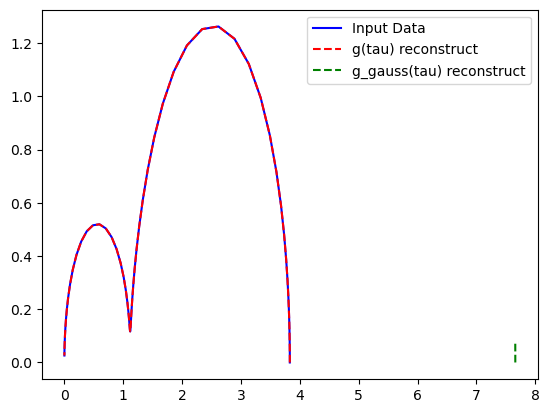

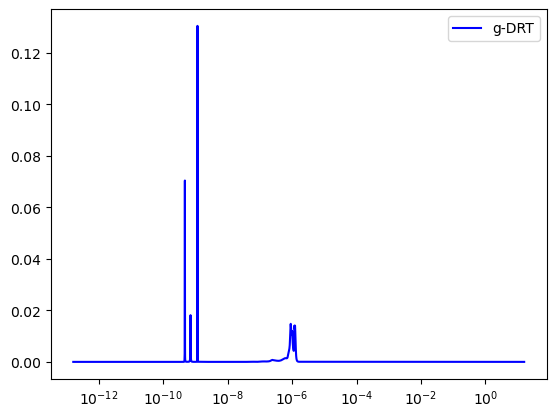

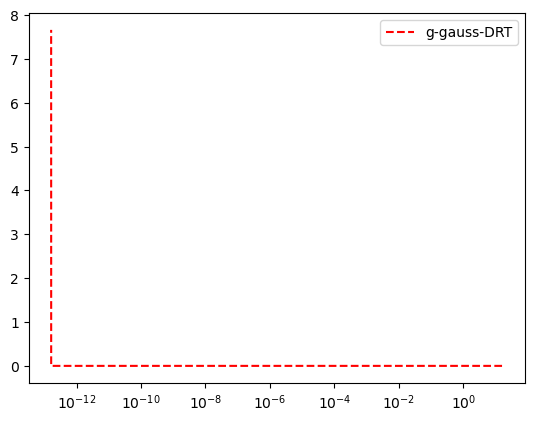

In [7]:
# 绘制拟合结果和DRT数据的峰值和高斯分布
#fig1,ax1=plt.subplots()
plt.figure()
plt.plot(z_re , -z_im , 'b', label='Input Data')
plt.plot(z_re_fit ,-z_im_fit , 'r--', label='g(tau) reconstruct')
plt.plot(z_re_fit_gauss , -z_im_fit_gauss , 'g--', label='g_gauss(tau) reconstruct')
plt.legend()
plt.show()

plt.figure()
plt.semilogx(tau , g , 'b', label='g-DRT')
plt.legend()
plt.show()

plt.semilogx(tau , g_gauss , 'r--', label='g-gauss-DRT')
plt.legend()